In [1]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *
from dysts.lyap import *

# try:
#     from private.lyap import corr_dim
# except:
#     from nolds import corr_dim


%load_ext autoreload
%autoreload 2

## Add a single dynamical system to the database

In [4]:
# We will make a local copy of the internal database
OUTPUT_FILE = "./chaotic_attractors2.json"
INPUT_FILE = "dysts/data/chaotic_attractors.json"
# INPUT_FILE = "./dysts/data/chaotic_attractors.json"
# INPUT_FILE = OUTPUT_FILE

with open(INPUT_FILE, "r") as file:
    data = json.load(file)
print(f"Total models being analyzed is {len(data.keys())}.")


for i, name in enumerate(get_attractor_list()):
#     if "dt" in data[name]:
#         continue
    
    if "Hyper" not in name:
        continue
        
    model = getattr(dysts.flows, name)()
    print(name)
    
    dt, period = compute_timestep(model, return_period=True)
    print(dt, period)

    data[name]["dt"] = dt
    data[name]["period"] = period
    # Save new file
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(data, f, indent=4)    

Total models being analyzed is 131.
HyperBao
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20
0.00030068702800142903 0.43736294982026047
HyperCai
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20
0.0003654032174278714 0.45854521402713266
HyperJha
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20
0.0003746954441920209 0.4282233647908811
HyperLorenz
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20
0.00028984341439371934 0.4215904209363191
HyperLu
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20
0.000315613385769233 0.4297714189198066
HyperPang
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 15 of 20
0.0003291356000406641 0.4388474667208855
HyperQi
Completed step 0 of 20
Completed step 5 of 20
Completed step 10 of 20
Completed step 1


period:  23.16075 



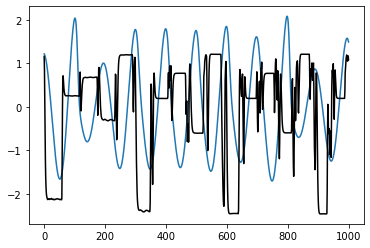

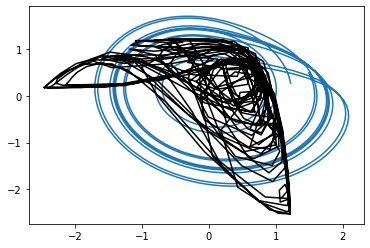

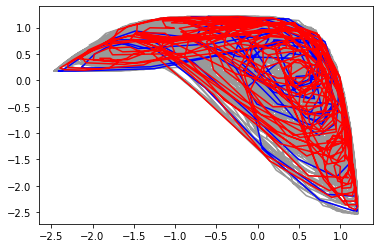

In [12]:
# Sanity check: plot a new system's trajectory. For single-modal attractors, there should be ~10 dominant peaks in interval

# Plot a reference trajectory as a sanity check
eq = Rossler()
sol0 = eq.make_trajectory(5000, resample=True, standardize=True)


eq = VossDelay()
# eq.ic = np.array([-0.6861051 ,  1.71118483, -2.79294469,  0.55636579])
# eq.dt *= 10
# eq.r *= 0.8
# eq.ic = np.array([-0.08541919, -0.05204435,  1.34515262])
# eq.dt /= 10
eq.period /= 2 / 10
# eq.period /= 2
# eq.period /= 20/10 * 8.5/10
# eq.dt = 0.01
# eq.period *= 5


sol = eq.make_trajectory(5000, resample=True, standardize=True, postprocess=True, pts_per_period=100)
# eq.ic = np.vstack([eq.ic, eq.ic])

plt.figure()
plt.plot(sol0[:1000, 0])
plt.plot(sol[:1000, 0], 'k')

plt.figure()
plt.plot(sol0[:1000, 0], sol0[:1000, 1])
plt.plot(sol[:1000, 0], sol[:1000, 1], 'k')

plt.figure()
plt.plot(sol[:, 0], sol[:, 1], color=(0.6, 0.6, 0.6))
plt.plot(sol[:500, 0], sol[:500, 1], "b")
plt.plot(sol[-500:, 0], sol[-500:, 1], "r")

print("\nperiod: ", eq.period, "\n")

# Find dynamical properties of each system

In [13]:
for i in range(10):
    print(i)
    if True:
        break

0


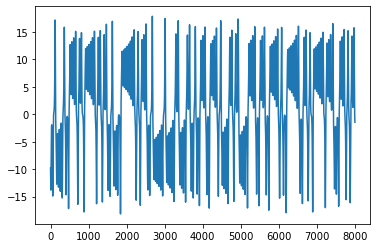

In [61]:
%matplotlib inline
plt.plot(sol[:, 0])

In [89]:
sol = MackeyGlass().make_trajectory(3000, resample=True, pts_per_period=100)
# mse_mv(sol)

In [124]:
sol = Lorenz().make_trajectory(8000, resample=True, pts_per_period=100)
mse_mv(sol)


0.8449090293662826

In [125]:
print(mse_mv(sol[:1000]))
print(mse_mv(sol[:1050]))
print(mse_mv(sol[:2000]))
print(mse_mv(sol[:3000]))
print(mse_mv(sol[:4000]))

1.2543590096684332
1.2182099968745383
1.134088853362469
1.083745197537921


In [126]:
print(mse_mv(sol[:4000]))

1.0453712886285025


In [109]:
%%bash
python3 find_attractor_properties.py

Process is terminated.


In [24]:
#Sort the JSON
with open(dysts.data_path, "r") as file:
    data = json.load(file)

# with open(dysts.data_path, 'w') as f:
#     json.dump(data, f, indent=4, sort_keys=True)
    


In [11]:
## find all Pesin entropies
with open(dysts.data_path, "r") as file:
    data = json.load(file)

all_ents = list()
for equation_name in get_attractor_list():
    model = getattr(dysts.flows, equation_name)()
    spec = np.array(model.lyapunov_spectrum_estimated)
    data[equation_name]["pesin_entropy"] = np.sum(spec[spec > 0])
    
# # Save new file
# with open(OUTPUT_FILE, 'w') as f:
#     json.dump(data, f, indent=4)

In [14]:



# We will make a local copy of the internal database
OUTPUT_FILE = "./chaotic_attractors2.json"
INPUT_FILE = dysts.data_path
# INPUT_FILE = OUTPUT_FILE
RECALCULATE = False
pts_per_trajectory = 3000 # number of timesteps to use to find the jacobian
divide_dt = 5 # factor by which to decrease dt, in order to improve calculation

# double
points_to_sample = 10 # number of initial conditions to sample and average when computing values

with open(INPUT_FILE, "r") as file:
    data = json.load(file)
print(f"Total models being analyzed is {len(data.keys())}.")



for i, item in enumerate(get_attractor_list()):
    
    lyap_flag = ("maximum_lyapunov_estimated" not in data[item]) or RECALCULATE
    lyap_flag = True
    print("Find Lyapunov?", lyap_flag)

    corr_flag = ("correlation_dimension" not in data[item]) or RECALCULATE
    corr_flag = True
    print("Find CorrDim?", corr_flag)

    entropy_flag = True
    print("Find MSE?", entropy_flag)
    


    model = getattr(dysts.flows, item)()
    
    ## skip delay models
    if hasattr(model, "delay"):
        if model.delay:
            continue

    print(str(i), item, ": ", end="")
    current_fields = list(data.keys())
    
    sample_pts = sample_initial_conditions(model, points_to_sample)

    all_estimates_lyap = list()
    all_estimates_corrdim = list()
    all_estimates_kydim = list()
    all_estimates_pesin = list()
    all_estimates_mmse = list()
    for j, sample_pt in enumerate(sample_pts):
        print(".", end="")
        model = getattr(dysts.flows, item)()
        model.dt /= divide_dt
        model.ic = sample_pt
        
        if lyap_flag:
            lyapval = find_lyapunov_exponents(model, 5 * pts_per_trajectory, pts_per_period=500)
            all_estimates_lyap.append(lyapval)
            all_estimates_kydim.append(kaplan_yorke_dimension(lyapval))
            all_estimates_pesin.append(np.sum(np.array(lyapval)[np.array(lyapval) > 0]))
            
            
        if corr_flag or entropy_flag:
            sol = model.make_trajectory(pts_per_trajectory, resample=True, pts_per_period=100)
            if corr_flag:
                try:
                    all_estimates_corrdim.append(corr_dim(sol))
                except:
                    print("Bad starting point; ignoring this")
                    pass
            if entropy_flag:
                all_estimates_mmse.append(mse_mv(sol))
                


    if lyap_flag:
        
        # lyap = np.median(np.array(all_estimates_lyap), axis=0)
        # kydim = np.median(all_estimates_kydim)
        # pesin_entropy = np.median(all_estimates_pesin)
        
        ## Weighted average based on quality of estimate
        all_estimates_lyap = np.array(all_estimates_lyap)
        lyap_weights = np.min(np.abs(all_estimates_lyap), axis=1)
        lyap_weights = np.exp(-lyap_weights * 1000)
        lyap_weights /= np.sum(lyap_weights )
        lyap = np.sum(lyap_weights[:, None] * all_estimates_lyap, axis=0) 
        
        kydim = np.sum(lyap_weights * np.array(all_estimates_kydim))
        pesin_entropy = np.sum(lyap_weights * np.array(all_estimates_pesin))
        
        data[item]["maximum_lyapunov_estimated"] = np.max(lyap)
        print(f"lyap: {np.max(lyap)} ", end="")
        
        data[item]["lyapunov_spectrum_estimated"] = list(lyap)
        print(f"spectrum: {lyap} ", end="")
        
        data[item]["kaplan_yorke_dimension"] = kydim
        print(f"kydim: {kydim} ", end="")
        
        data[item]["pesin_entropy"] = pesin_entropy
        print(f"pesin: {pesin_entropy} ", end="")

    if corr_flag:
        if lyap_flag:
            cdim = np.sum(lyap_weights * np.array(all_estimates_corrdim))
        else:
            cdim = np.median(all_estimates_corrdim)
        data[item]["correlation_dimension"] = cdim
        print(f"corr_dim: {cdim} ", end="")
        
    if entropy_flag:
        if lyap_flag:
            ent = np.sum(lyap_weights * np.array(all_estimates_mmse))
        else:
            ent = np.median(all_estimates_mmse)
        data[item]["multiscale_entropy"] = ent
        print(f"multiscale_entropy: {ent} ", end="")


    print("\n", flush=True)


#     break

    # Save new file
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(data, f, indent=4)

#     except:
#         print(f"Skipped {item}")
#         continue

print("Completed.")



Total models being analyzed is 131.
Find Lyapunov? True
Find CorrDim? True
Find MSE? True
0 Aizawa : .Bad starting point; ignoring this
.Bad starting point; ignoring this
.Bad starting point; ignoring this
.Bad starting point; ignoring this
.Bad starting point; ignoring this
.Bad starting point; ignoring this
.Bad starting point; ignoring this
.Bad starting point; ignoring this
.Bad starting point; ignoring this
.Bad starting point; ignoring this
lyap: 0.08940806095204462 spectrum: [ 0.08940806  0.00615385 -0.28595246] kydim: 2.3339870669195704 pesin: 0.09556190991127829 

Traceback (most recent call last):
  File "attractor_properties.py", line 115, in <module>
    cdim = np.sum(lyap_weights * np.array(all_estimates_corrdim))
ValueError: operands could not be broadcast together with shapes (10,) (0,) 


CalledProcessError: Command 'b'python3 attractor_properties.py\n'' returned non-zero exit status 1.

In [15]:
%%bash
python3 find_attractor_properties.py

Process is interrupted.


In [9]:
model.rhs(model.ic, 0)

0.6443324705297677

In [11]:
if len(np.asarray(model(np.array(model.ic), 0)).shape) < len(model.ic):
    warnings.warn(f"{model.name} dynamical equation is not full-rank; approximating instead")
    
    def rhsy(x):
        np.array()
        return np.squeeze(np.array(model.make_trajectory(1, resample=False) - model.ic))
        
#         = lambda x: (model.make_trajectory(1, resample=False) - model.ic) np.array(model.rhs(x, tpts[i]))
else:
    rhsy = lambda x: np.array(model.rhs(x, tpts[i]))
    
    
mm = jac_fd(rhsy, model.ic)

<ipython-input-11-baae7a88415e>:2: UserWarning: MackeyGlass dynamical equation is not full-rank; approximating instead
  warnings.warn(f"{model.name} dynamical equation is not full-rank; approximating instead")


TypeError: array() missing required argument 'object' (pos 1)

array([[-0.18717447,  0.87590449, -0.34923471, -0.17837253,  0.38595488,
        -0.0990977 , -0.53518497,  0.66653575, -0.40709927,  0.06008729]])

In [57]:

jac_fd(np.array(model.ic), row_func)

TypeError: len() of unsized object

-0.18696531115613002

In [51]:
all_estimates_mmse

[0.30561014185009044,
 0.2640259672738763,
 0.29242213639086595,
 0.27477238747629396,
 0.2973289189960061,
 0.2610222159508139,
 0.2695949845358253,
 0.28359024532000254,
 0.27002018809610656,
 0.26976258332520114]

In [41]:
np.sum(lyap_weights * np.array(all_estimates_pesin))

0.16017195719462463

In [40]:
pesin_entropy 

1.4431033707701124

In [35]:
np.sum(lyap_weights * np.array(all_estimates_corrdim))

1.806276399767798

In [36]:
all_estimates_corrdim

[1.9497806405256808,
 1.8824501616817793,
 1.8986021976874035,
 1.8035166170508117,
 1.8806688199266015,
 1.8903468454470806,
 1.9103345474757707,
 1.9429282088846729,
 1.874908588555704,
 1.8428934409930395]

In [22]:
all_estimates_lyap

array([[ 0.0677099 ,  0.05220583, -0.28041859],
       [ 0.13373401,  0.04587205, -0.36265083],
       [ 0.15153579,  0.02692717, -0.35008565],
       [ 0.15202684,  0.00915055, -0.37707788],
       [ 0.11164019,  0.02412739, -0.33814824],
       [ 0.11701861,  0.01256812, -0.2918716 ],
       [ 0.10237211,  0.05965405, -0.36571558],
       [ 0.02398487,  0.01990871, -0.03614866],
       [ 0.13995605,  0.0279833 , -0.36004354],
       [ 0.13441779,  0.03031004, -0.33734228]])

In [26]:
all_estimates_kydim

array([1.94978064, 1.88245016, 1.8986022 , 1.80351662, 1.88066882,
       1.89034685, 1.91033455, 1.94292821, 1.87490859, 1.84289344])

In [24]:
cdim

18.876430068228544

## Check for database issues

In [ ]:
FILE1 = "./chaotic_attractors.json"
FILE2 = "./6_6_chaotic_attractors.json"

with open(FILE1, "r") as file:
    data1 = json.load(file)
with open(FILE2, "r") as file:
    data2 = json.load(file)
    
keyval = "maximum_lyapunov_estimated"
# keyval = "correlation_dimension"
# keyval = "kaplan_yorke_dimension"
for name in np.sort(list(data1.keys())):
    
    try:
        val1 = data1[name][keyval]
        val2 = data2[name][keyval]
    except:
        print("failed: ", name)
        
    try:
        pcent = np.abs((val1 - val2) / val1)
#         pcent = np.abs(np.sign(val1) - np.sign(val2))
        if np.abs(pcent) > 0.12:
            print(name, pcent)
    except:
        print("failed2: ", name)